In [97]:
# путь до папки scripts с необходимыми скриптами
libpath = "../scripts"
import sys
# добавляем в PATH папку libpath для дальнейшего импорта 
sys.path.append(libpath)
from preprocessing import TsfreshDatasetTransformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tsfresh.transformers import RelevantFeatureAugmenter, FeatureAugmenter

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:

class ParseToPandas():
    """
    Класс для парсинга данных из папок двух типов:
    1) Папок со вложенной структурой (список путей в paths_to_nested)
    2) Папок без вложенной структуры (один hdf5 - один тип воздействий) (список путей в old_paths)
    
    Парсинг происходит при вызове инициализатора. При вызове __init__ возвращается 
    pd.DataFrame с тремя колонками: id, time, signal_raw
    
    Есть вспомогательные методы ():
    * concat_datasets - объединяет данные с нескольких источников
    
    * rename_idxs - переименовывает id у воздействий после склейки
    
    * drop_classes - удаляет некоторые типы воздействий из датасета.
    (Например unknown - неизвестное воздействие, у которого неизвестна метка классификации)
    
    * rename_classes - переименовывает некоторые воздействия 
    в соответствии со словарем {"старое_название": "новое_название"}
    
    * truncate_classes - делает одинаковое кол-во воздействий каждого класса. 
    (Downsampling избыточные классы) 
     
    """
    def __init__(self, paths_to_nested: list[str], old_paths: list[str] = None,
                labels_to_delete: list[str] = None, dict_to_rename: dict[str, str] = None,
                balanced_classes: bool = False) -> pd.DataFrame:
        
        self.paths_to_nested = paths_to_nested
        self.old_paths = old_paths
        self.data_getter = TsfreshDatasetTransformer()
        self.list_of_datasets = []
        
        
        for path in paths_to_nested:
            self.list_of_datasets.append(
                self.data_getter.make_tsfresh_structure_from_nested_directory(path)
            )
        if old_paths:
            for path in old_paths:
                self.list_of_datasets.append(
                    self.data_getter.make_tsfresh_structure_from_simple_directory(path)
                )
        self.data_hdf5, self.label_hdf5 = self.concat_datasets()
        
        if labels_to_delete:
            self.drop_classes(labels_to_delete)
        if dict_to_rename:
            self.rename_classes(dict_to_rename)
        
        self.data_hdf5["id"] = self.rename_idxs(self.data_hdf5["id"])
        self.data_hdf5.reset_index(drop=True, inplace=True)
        self.label_hdf5.reset_index(drop=True, inplace=True)
        if balanced_classes:
            self.truncate_classes()
        
        self.id_to_label = dict(enumerate(self.label_hdf5.unique()))
        self.label_to_id = {i: j for j, i in self.id_to_label.items()}
        self.indexes = self.label_hdf5.index
    def concat_datasets(self):
        # Соединяет несколько датасетов
        concated_dataframe = pd.DataFrame([])
        concated_labels = []
        current_id = 0
        for (data, label) in self.list_of_datasets:
            data_copy = data.copy()
            data_copy["id"] += current_id
            concated_dataframe = pd.concat([concated_dataframe, data_copy], ignore_index=True)
            current_id = concated_dataframe["id"].iloc[-1] +1
            concated_labels.extend(label)
        return concated_dataframe, pd.Series(concated_labels)

    def rename_idxs(self, array):
        # Переименовывает колонку id после удаления метки
        a = array.copy()
        a = np.array(a)
        i = 1
        while i < len(a):
            if a[i] - a[i-1] > 1:
                j = i
                constant = a[j]
                while j < len(a) and a[j] == constant:
                    a[j] = a[i-1] + 1
                    j += 1
                i = j
            else:
                i += 1
        if a[0] > 0:
            a -= a[0]
        return a
    
    def drop_classes(self, labels_to_delete: list[str]):
        mask_drop = self.label_hdf5.isin(labels_to_delete)
        drop_idxs =  self.label_hdf5[mask_drop].index # id of drop labels

        self.data_hdf5.drop(
            index = self.data_hdf5[self.data_hdf5["id"].isin(drop_idxs)].index,
            inplace=True
        )
        self.label_hdf5.drop(
            index = drop_idxs,
            inplace = True
        )
    
    def rename_classes(self, dict_to_rename: dict[str, str]):
        for key, item in dict_to_rename.items():
            self.label_hdf5.replace(key, item, inplace=True)

    def truncate_classes(self):
        idxs_after_truncate = np.array([], dtype=np.uint16) 
        interaction_count = self.label_hdf5.value_counts().min()

        for interaction_name in self.label_hdf5.unique():
            idxs_after_truncate = np.append(idxs_after_truncate, 
                                            self.label_hdf5[self.label_hdf5==interaction_name].
                                            keys().
                                            to_numpy(np.uint16)[:interaction_count])
        idxs_after_truncate.sort()
        self.label_hdf5 = self.label_hdf5.loc[idxs_after_truncate]
        self.data_hdf5 = self.data_hdf5[self.data_hdf5["id"].isin(idxs_after_truncate)]

In [5]:
paths_to_nested = ["/home/drozdovmk/Projects/ZB/data/data_markup/cesis_nabor_0",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/demostend_0",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/samara_wind",
                   "/home/drozdovmk/Projects/ZB/data/data_markup/Kashira_13may"]

old_paths = ["/home/drozdovmk/Projects/ZB/data/data_markup/hdf5_adaptive"]

labels_to_delete = ["hit_series", "unknown"]
dict_to_rename = {"hit_g": "hit", "hit_z": "hit"}
balanced_classes = False


dataset = ParseToPandas(paths_to_nested=paths_to_nested,
                        old_paths=old_paths,
                        labels_to_delete=labels_to_delete,
                        dict_to_rename=dict_to_rename,
                        balanced_classes=balanced_classes)


Found unknown label in zone 455 
date: 23/12/2024 14:57:52
Found unknown label in zone 737 
date: 24/12/2024 05:47:32
Found unknown label in zone 737 
date: 24/12/2024 05:51:41
Found unknown label in zone 737 
date: 24/12/2024 14:41:29
Found unknown label in zone 737 
date: 24/12/2024 14:41:39
Found unknown label in zone 737 
date: 24/12/2024 06:08:46
Found unknown label in zone 737 
date: 24/12/2024 16:17:34
Found unknown label in zone 737 
date: 24/12/2024 16:17:49
Found unknown label in zone 775 
date: 13/05/2025 11:39:49
Found unknown label in zone 775 
date: 13/05/2025 12:40:28
Found unknown label in zone 775 
date: 13/05/2025 12:40:34
Found unknown label in zone 775 
date: 13/05/2025 12:40:40
Found unknown label in zone 775 
date: 13/05/2025 12:40:52
Found unknown label in zone 610 
date: 13/05/2025 05:57:58
Found unknown label in zone 610 
date: 13/05/2025 14:04:13
Found unknown label in zone 610 
date: 13/05/2025 14:23:49
Found unknown label in zone 610 
date: 13/05/2025 14:25:

In [99]:
dataset.data_hdf5

,id,time,signal_raw
0,0,0,8966.0
1,0,1,9039.0
2,0,2,8957.0
3,0,3,8981.0
4,0,4,8904.0
...,...,...,...
10520531,1951,1958,3911.0
10520532,1951,1959,3980.0
10520533,1951,1960,3926.0
10520534,1951,1961,3924.0


In [26]:
data_hdf5 = dataset.data_hdf5
labels = dataset.label_hdf5
print("Статистика по классам:")
print(labels.value_counts())

Статистика по классам:
wind       956
hit        553
saw        235
perelaz    208
Name: count, dtype: int64


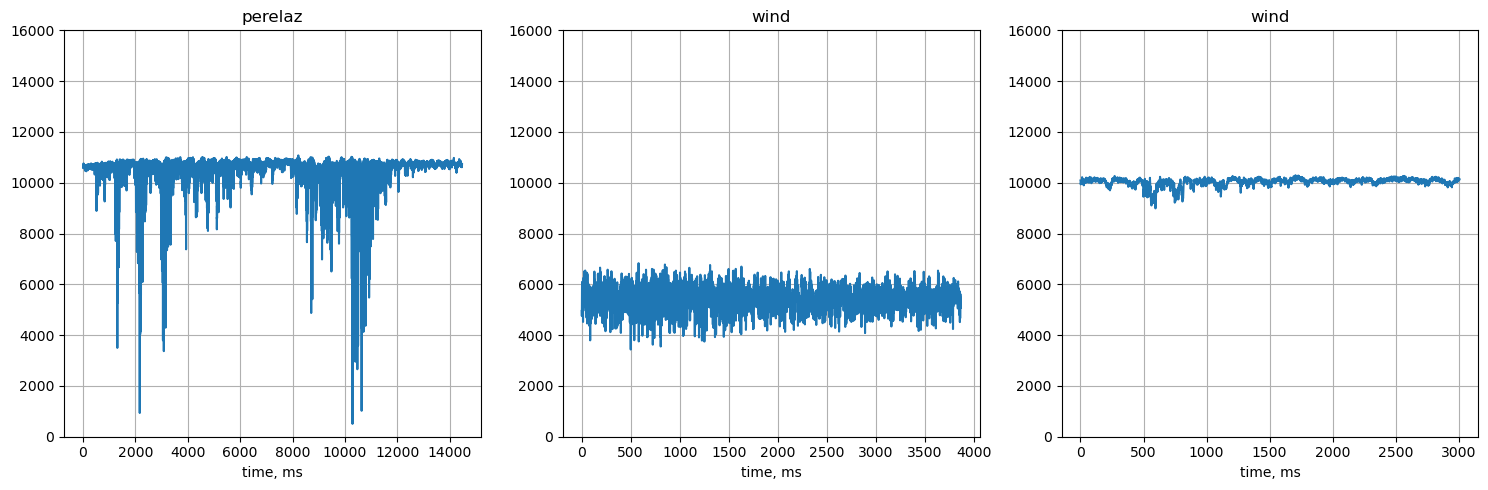

In [63]:
# Визуализация нескольких объектов
number_of_samples = 3
random_indexes = np.random.choice(data_hdf5["id"].unique(), size=number_of_samples)
fig, ax = plt.subplots(1, number_of_samples, figsize=(5*number_of_samples,5))

for i, ind in enumerate(random_indexes):
    
    ax[i].plot(data_hdf5[data_hdf5["id"] == ind].time,
               data_hdf5[data_hdf5["id"] == ind].signal_raw)
    ax[i].set_ylim([0, 16000])
    ax[i].set_title(labels[ind])
    ax[i].set_xlabel("time, ms")
    ax[i].grid()
plt.tight_layout()

In [64]:
from preprocessing import FeaturesToTsfresh, Preprocessor

In [65]:
pr = Preprocessor()
long_signal, df_ts_freq, df_ts_time = pr.transform(data_hdf5, from_numpy=False)

In [66]:

X_idxs = pd.DataFrame(index=df_ts_freq["id"].unique())
X_idxs_train, X_idxs_test, y_train, y_test = train_test_split(X_idxs,
                                                              labels,
                                                              test_size=0.1,
                                                              stratify=labels)

In [69]:
def create_pipeline():
    fft_features_extractor = Pipeline([
            (
                  'augmenter', RelevantFeatureAugmenter(
                        column_id='id',
                        column_sort='freq_num',
                        default_fc_parameters= FeaturesToTsfresh().get_freq_domain_features(),
                        multiclass=True,
                        n_significant=labels.nunique(),
                        disable_progressbar=True
                        )
            ),
      ])
    time_features_extractor = Pipeline([
                (
                    'augmenter', FeatureAugmenter(
                            column_id='id',
                            column_sort='time',
                            kind_to_fc_parameters= FeaturesToTsfresh().get_time_domain_features(),
                            disable_progressbar=True
                            )
                ),
        ])

    feature_union = FeatureUnion([
        ("fft_features_extractor", fft_features_extractor),
        ("time_features_extractor", time_features_extractor)
        ])

    result_ppl = Pipeline([
        ("feature_extraction", feature_union),
        ("model", RandomForestClassifier(
                class_weight = "balanced_subsample",
                n_estimators = 100,
                max_depth = 10,
                min_samples_leaf=5))
        ])
    return result_ppl

In [70]:

df_ts_freq_train = df_ts_freq[df_ts_freq["id"].isin(y_train.index)]
df_ts_time_train = df_ts_time[df_ts_time["id"].isin(y_train.index)]


result_ppl = create_pipeline()

result_ppl["feature_extraction"]["fft_features_extractor"].set_params(
      augmenter__timeseries_container=df_ts_freq_train
      );
result_ppl["feature_extraction"]["time_features_extractor"].set_params(
      augmenter__timeseries_container=df_ts_time_train
      );


In [71]:

result_ppl.fit(X_idxs_train, y_train)
train_pred = result_ppl.predict(X_idxs_train)


In [72]:
result_ppl

Pipeline(steps=[('feature_extraction',
                 FeatureUnion(transformer_list=[('fft_features_extractor',
                                                 Pipeline(steps=[('augmenter',
                                                                  RelevantFeatureAugmenter(column_id='id',
                                                                                           column_sort='freq_num',
                                                                                           default_fc_parameters={'abs_energy': None,
                                                                                                                  'absolute_maximum': None,
                                                                                                                  'absolute_sum_of_changes': None,
                                                                                                                  'agg_autocorrelation': [{'f_agg': 'mean',
                                                                                                                                           'maxlag': 40},
                                                                                                                                          {'f_agg': 'media...
4            0     4      8904.0      0.015533        0.651792
...        ...   ...         ...           ...             ...
10520531  1951  1958      3911.0      0.022263        0.260951
10520532  1951  1959      3980.0      0.021355        0.261157
10520533  1951  1960      3926.0      0.021872        0.261444
10520534  1951  1961      3924.0      0.022496        0.261946
10520535  1951  1962      3874.0      0.023154        0.262165

[9501204 rows x 5 columns]))]))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, min_samples_leaf=5))])

In [73]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

         hit       0.97      0.98      0.98       498
     perelaz       0.96      0.96      0.96       187
         saw       0.98      1.00      0.99       211
        wind       0.99      0.98      0.98       860

    accuracy                           0.98      1756
   macro avg       0.97      0.98      0.98      1756
weighted avg       0.98      0.98      0.98      1756



In [75]:

df_ts_freq_test = df_ts_freq[df_ts_freq["id"].isin(y_test.index)]
df_ts_time_test = df_ts_time[df_ts_time["id"].isin(y_test.index)]

result_ppl["feature_extraction"]["fft_features_extractor"].set_params(augmenter__timeseries_container=df_ts_freq_test);
result_ppl["feature_extraction"]["time_features_extractor"].set_params(augmenter__timeseries_container=df_ts_time_test);


In [76]:

test_pred = result_ppl.predict(X_idxs_test)

In [21]:
from sklearn.metrics import roc_auc_score

print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         hit       0.91      0.95      0.93        21
     perelaz       1.00      0.90      0.95        21
         saw       1.00      1.00      1.00        21
        wind       0.95      1.00      0.98        21

    accuracy                           0.96        84
   macro avg       0.97      0.96      0.96        84
weighted avg       0.97      0.96      0.96        84



## Обучаем итоговую модель

In [87]:

result_ppl = create_pipeline()
result_ppl["feature_extraction"]["fft_features_extractor"].set_params(
      augmenter__timeseries_container=df_ts_freq
      );
result_ppl["feature_extraction"]["time_features_extractor"].set_params(
      augmenter__timeseries_container=df_ts_time
      );

data_idxs = pd.DataFrame(index=data_hdf5["id"].unique())
result_ppl.fit(data_idxs, labels)



Pipeline(steps=[('feature_extraction',
                 FeatureUnion(transformer_list=[('fft_features_extractor',
                                                 Pipeline(steps=[('augmenter',
                                                                  RelevantFeatureAugmenter(column_id='id',
                                                                                           column_sort='freq_num',
                                                                                           default_fc_parameters={'abs_energy': None,
                                                                                                                  'absolute_maximum': None,
                                                                                                                  'absolute_sum_of_changes': None,
                                                                                                                  'agg_autocorrelation': [{'f_agg': 'mean',
                                                                                                                                           'maxlag': 40},
                                                                                                                                          {'f_agg': 'media...
4            0     4      8904.0      0.015533        0.651792
...        ...   ...         ...           ...             ...
10520531  1951  1958      3911.0      0.022263        0.260951
10520532  1951  1959      3980.0      0.021355        0.261157
10520533  1951  1960      3926.0      0.021872        0.261444
10520534  1951  1961      3924.0      0.022496        0.261946
10520535  1951  1962      3874.0      0.023154        0.262165

[10520536 rows x 5 columns]))]))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, min_samples_leaf=5))])

Построение калибровочных графиков

In [88]:
probas = result_ppl.predict_proba(data_idxs)

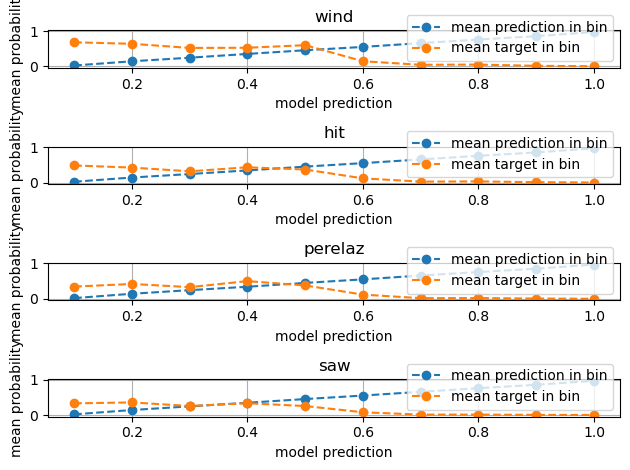

In [96]:
intervals_vs_pred = {i/10: [] for i in range(1,11)}
intervals_vs_target = {i/10: [] for i in range(1,11)}
classes = labels.unique()

for i, intrusion in enumerate(classes):
    real_targets = np.where(labels.to_numpy()==classes[i], 1, 0)
    probs = probas[:, i]
    keys = np.round(probs - (probs%0.1) + 0.1, 1)
    
    for j in range(len(probs)):
        intervals_vs_pred[keys[j]].append(probs[j])
        intervals_vs_target[keys[j]].append(real_targets[j])
        
    intervals_vs_mean_pred={key: np.mean(val) for key, val in intervals_vs_pred.items()}
    intervals_vs_mean_target={key: np.mean(val) for key, val in intervals_vs_target.items()}
    plt.subplot(len(classes),1,i+1)

    plt.plot(intervals_vs_mean_pred.keys(), intervals_vs_mean_pred.values(),
            linestyle='dashed', marker="o", label="mean prediction in bin")
    plt.plot(intervals_vs_mean_target.keys(), intervals_vs_mean_target.values(),
            linestyle='dashed',marker="o", label="mean target in bin")
    plt.title(classes[i])
    plt.xlabel("model prediction")
    plt.ylabel("mean probability")
    plt.grid()
    plt.legend()
plt.tight_layout()

Сохранение модели

In [23]:
import os
os.listdir('../..')
import joblib

# Убираем датасеты из pipeline (неудобно у tsfresh сделано)
result_ppl["feature_extraction"]["fft_features_extractor"].set_params(
      augmenter__timeseries_container=pd.DataFrame(index=[0])
      );
result_ppl["feature_extraction"]["time_features_extractor"].set_params(
      augmenter__timeseries_container=pd.DataFrame(index=[0])
      );
joblib.dump(result_ppl, '../../RnD/classifier_v4/pipeline_with_kashira.pkl')

['../../RnD/classifier_v4/pipeline_with_kashira.pkl']

Построим калибровочные графики

In [77]:
intervals_vs_pred = {i/10: [] for i in range(1,11)}
intervals_vs_target = {i/10: [] for i in range(1,11)}
classes = labels.unique()

for i, intrusion in enumerate(classes):
    real_targets = np.where(y_train.to_numpy()==classes[i], 1, 0)
    probs = probas[:, i]
    keys = np.round(probs - (probs%0.1) + 0.1, 1)
    
    for i in range(len(probs)):
        intervals_vs_pred[keys[i]].append(probs[i])
        intervals_vs_target[keys[i]].append(real_targets[i])
        
    intervals_vs_mean_pred={key: np.mean(val) for key, val in intervals_vs_pred.items()}
    intervals_vs_mean_target={key: np.mean(val) for key, val in intervals_vs_target.items()}
    plt.subplot(1,len(classes),i )

    plt.plot(intervals_vs_mean_pred.keys(), intervals_vs_mean_pred.values(),
            linestyle='dashed', marker="o", label="mean prediction in bin")
    plt.plot(intervals_vs_mean_target.keys(), intervals_vs_mean_target.values(),
            linestyle='dashed',marker="o", label="mean target in bin")
    plt.title(classes[i])
    plt.xlabel("model prediction")
    plt.ylabel("mean probability")
    plt.grid()
    plt.legend()

NameError: name 'train_pred_proba' is not defined

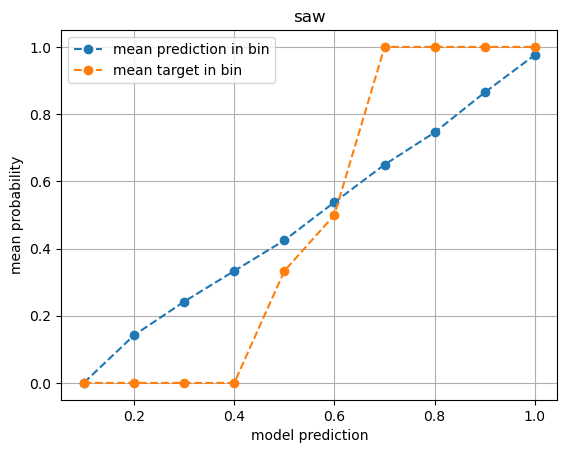